#Análise de dados de pesquisas farmacológicas

## Mas do que se tratam estes dados que serão análisados?

![Human Evolution](https://github.com/wfercosta/imersao-dados-desafio-final/blob/main/Notebooks/human-evolution.jpg?raw=true)


A humanidade, por milênios, a cada nova situação que nos é imposto, nos desafiam a dar mais um passo adiante na nossa evolução. Seja por que este novo contexto exige um esforço para garantir não somente a nossa sobrevivência e de nossas futuras gerações, mas as vezes também para melhoramos algum aspecto da sociedade, como qualidade de vida, transportes e meios de comunicações mais eficientes, segurança e etc. E com a medicina, principalmente na no que tange aos *__farmacológicos__*, não seria diferente.

<br>

> _"A busca por medicamentos para o alívio de sintomas e tratamento de doenças talvez seja uma das práticas mais antigas da nossa sociedade." (DRUG, 2021)_

<br>

Em dezembro de 2019, fomos supreendidos com o improvável. Um **_"cisne negro"_** (TALEB, 2019). Um novo patógeno conhecido como SARS-CoV-2 (CORNAVÍRUS, 2021) que rapidamente se tornou uma crise pandêmica (PANDEMIA, 2021) em escala mundial, cujo desencadeia uma nova doença respiratória por Coronavírus (COVID-19, 2021). 

Este "cisne negro", aliado ao instinto de sobrevivência, propiciou avanços significativos no desenvolvimento de novas vacinas, como o desenvolvimento de vacinas que usam RNA mensageiro (VACINA, 2021), além do tempo recorde para disponbilização para a população. 

Embora existam críticas éticas com relação a esta história, não podemos deixar de mencionar que estes feitos somente foram possíveis graças ao *Dr. George Gey* que em 1 de fevereiro de 1951, em seu primeiro contato com a *Henrietta Lacks*, encontrou na dor e no sofrimento dela, um tumor de colo de útero, com características únicas e singulares. Passado alguns meses, após 30 anos pesquisando como cultivar células em laboratório, em outubro de 1951, após a morte de *Henrietta* e coletar amostras de suas células cancerígenas, finalmente a sua pesquisa teve resultados. E desde então, as células de *Henrietta Lacks*, agora imortais, também conhecidas como céluas *__HeLa__*, são cultivadas em escala e usadas no mundo todo para pesquisas que avaliam as ativações celulares diante à exposições dos mais diversos compostos químicos que darão origem a novos medicamentos e cosméticos (A HISTÓRIA, 2017). 


## Preparação dos dados e limpeza

### Importações de bibliotecas e configurações globais

In [147]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import combinations

sns.set()

### Funções utilitárias

In [148]:
"""
Esta área é dedicada a implementação de funções utilitárias
e para reuso de lógicas que serão utilizadas  ao longo 
deste notebook
"""

def print_df_dict_groupby(d, indent=0):
  """Função responsável por imprimir uma estrura de dicionário
     do pandas quando for realizando um group by

  Parameters:
  d (dict): Dictionary
  indent(int): Indentation, default 0

  """
  print(type(d))
  for key, value in d.items():
    print('\t' * indent + str(key))
    if isinstance(value, dict):
      print_dict(value, indent + 1)
    else:
      values = value.tolist()
      for i in range(0, len(values), 50):
        print('\t' * (indent + 1) + ', '.join(map(str, values[i: i + 50])) + '\n')

def plot_chart_pie(series: pd.core.series.Series, title = 'Title not defined', **kwargs):
  """ Função responsável por imprimir um gráfico de pizza
      com base em um Série do pandas.

  Parameters:
    series (pandas.core.series.Series): Série a ser 'plotada'
    title (str): Título do gráfico

    O restante dos argumentos são os mesmos suportados pelo pandas.core.series.Series.plot.pie()

  """

  colors=['#8b9fc0', \
          '#f0ad4e', \
          '#d24726', \
          '#87cefa', \
          '#3e6b87', \
          '#e14f4e', \
          '#ff7bac', \
          '#fed800', \
          '#edc4ab', \
          '#8cc640']

  
  kwargs.setdefault('autopct', '%1.0f%%')
  kwargs.setdefault('textprops', {'fontsize': 12})
  kwargs.setdefault('colors', colors)

  kwargs.pop('title', None)
  
  plt.figure(figsize=(6, 6))
  plt.figtext(.5,.9, title, fontsize=15, ha='center')
  ax = series.plot.pie(**kwargs)
  ax.set_ylabel(None)

  plt.show()


def plot_chart_histogram(series: pd.core.series.Series, \
                         title='No title defined', \
                         y_label='no label', \
                         x_label='no_label', **kwargs):
  """Função responsável plotar o um gráfico de histogram em cima
  de uma série do pandas

  Parameters:
  series (pandas.core.series.Series): Série a ser 'plotada'
  title (str): Título do gráfico
  y_label (str): Rótulo do eixo y
  x_label (str): Rótulo do eixo x

  O restante dos argumentos são os mesmos suportados pelo sns.histplot()

  """
  
  kwargs.setdefault('bins', 100)
  plt.figure(figsize=(8, 6))
  ax = sns.histplot(data=series, **kwargs)
  ax.set_title(title,fontsize=20)
  ax.set_ylabel(y_label, fontsize=15)
  ax.set_xlabel(x_label, fontsize=15)
  plt.show()


def plot_chart_correlations_heatmap(correlations):

  """Função responsável plotar um heatmap com as correlações

  Parameters:
  correlations: correlações

  """

  # Generate a mask for the upper triangle
  mask = np.triu(np.ones_like(correlations, dtype=bool))

  # Set up the matplotlib figure
  f, ax = plt.subplots(figsize=(11, 9))

  # Generate a custom diverging colormap
  cmap = sns.diverging_palette(230, 20, as_cmap=True)

  # Draw the heatmap with the mask and correct aspect ratio
  sns.heatmap(correlations, mask=mask, cmap=cmap, center=0,
              square=True, linewidths=.5, cbar_kws={"shrink": .5})

def filter_correlation(df, thresh_hold):

    """Função responsável filtar as correlações de forma permitr que 
    grandes matrizes possam ser impressas.

    Parameters:
    df: data frame
    thresh_hold: limite usado para filtro

    """

    passed = set()
    for (r,c) in combinations(df.columns, 2):
        if (abs(df.loc[r,c]) >= thresh_hold):
            passed.add(r)
            passed.add(c)
    passed = sorted(passed)
    return df.loc[passed,passed]

###
Importação dos datasets

In [149]:
"""
Este dataset refere-se aos dados de experimentos que foram realizados
com vários compostos químicos
"""
df_experiments_url = 'https://github.com/wfercosta/imersao-dados-desafio-final/blob/main/Dados/dados_experimentos.zip?raw=true'
df_experiments = pd.read_csv(df_experiments_url, compression='zip')
df_experiments.head()

,id,tratamento,tempo,dose,droga,g-0,g-1,g-2,g-3,g-4,g-5,g-6,g-7,g-8,g-9,g-10,g-11,g-12,g-13,g-14,g-15,g-16,g-17,g-18,g-19,g-20,g-21,g-22,g-23,g-24,g-25,g-26,g-27,g-28,g-29,g-30,g-31,g-32,g-33,g-34,...,c-60,c-61,c-62,c-63,c-64,c-65,c-66,c-67,c-68,c-69,c-70,c-71,c-72,c-73,c-74,c-75,c-76,c-77,c-78,c-79,c-80,c-81,c-82,c-83,c-84,c-85,c-86,c-87,c-88,c-89,c-90,c-91,c-92,c-93,c-94,c-95,c-96,c-97,c-98,c-99
0,id_000644bb2,com_droga,24,D1,b68db1d53,1.0620,0.5577,-0.2479,-0.6208,-0.1944,-1.0120,-1.0220,-0.0326,0.5548,-0.0921,1.1830,0.1530,0.5574,-0.4015,0.1789,-0.6528,-0.7969,0.6342,0.1778,-0.3694,-0.5688,-1.1360,-1.1880,0.6940,0.4393,0.2664,0.1907,0.1628,-0.2853,0.5819,0.2934,-0.5584,-0.0916,-0.3010,-0.1537,...,0.4805,0.4965,0.3680,0.8427,0.1042,0.1403,0.1758,1.2570,-0.5979,1.2250,-0.0553,0.7351,0.5810,0.9590,0.2427,0.0495,0.4141,0.8432,0.6162,-0.7318,1.2120,0.6362,-0.4427,0.1288,1.4840,0.1799,0.5367,-0.1111,-1.0120,0.6685,0.2862,0.2584,0.8076,0.5523,-0.1912,0.6584,-0.3981,0.2139,0.3801,0.4176
1,id_000779bfc,com_droga,72,D1,df89a8e5a,0.0743,0.4087,0.2991,0.0604,1.0190,0.5207,0.2341,0.3372,-0.4047,0.8507,-1.1520,-0.4201,-0.0958,0.4590,0.0803,0.2250,0.5293,0.2839,-0.3494,0.2883,0.9449,-0.1646,-0.2657,-0.3372,0.3135,-0.4316,0.4773,0.2075,-0.4216,-0.1161,-0.0499,-0.2627,0.9959,-0.2483,0.2655,...,0.4083,0.0319,0.3905,0.7099,0.2912,0.4151,-0.2840,-0.3104,-0.6373,0.2887,-0.0765,0.2539,0.4443,0.5932,0.2031,0.7639,0.5499,-0.3322,-0.0977,0.4329,-0.2782,0.7827,0.5934,0.3402,0.1499,0.4420,0.9366,0.8193,-0.4236,0.3192,-0.4265,0.7543,0.4708,0.0230,0.2957,0.4899,0.1522,0.1241,0.6077,0.7371
2,id_000a6266a,com_droga,48,D1,18bb41b2c,0.6280,0.5817,1.5540,-0.0764,-0.0323,1.2390,0.1715,0.2155,0.0065,1.2300,-0.4797,-0.5631,-0.0366,-1.8300,0.6057,-0.3278,0.6042,-0.3075,-0.1147,-0.0570,-0.0799,-0.8181,-1.5320,0.2307,0.4901,0.4780,-1.3970,4.6240,-0.0437,1.2870,-1.8530,0.6069,0.4290,0.1783,0.0018,...,-0.5477,-0.7576,-0.0444,0.1894,-0.0014,-2.3640,-0.4682,0.1210,-0.5177,-0.0604,0.1682,-0.4436,0.4963,0.1363,0.3335,0.9760,-0.0427,-0.1235,0.0959,0.0690,-0.9416,-0.7548,-0.1109,-0.6272,0.3019,0.1172,0.1093,-0.3113,0.3019,-0.0873,-0.7250,-0.6297,0.6103,0.0223,-1.3240,-0.3174,-0.6417,-0.2187,-1.4080,0.6931
3,id_0015fd391,com_droga,48,D1,8c7f86626,-0.5138,-0.2491,-0.2656,0.5288,4.0620,-0.8095,-1.9590,0.1792,-0.1321,-1.0600,-0.8269,-0.3584,-0.8511,-0.5844,-2.5690,0.8183,-0.0532,-0.8554,0.1160,-2.3520,2.1200,-1.1580,-0.7191,-0.8004,-1.4670,-0.0107,-0.8995,0.2406,-0.2479,-1.0890,-0.7575,0.0881,-2.7370,0.8745,0.5787,...,-2.1220,-0.3752,-2.3820,-3.7350,-2.9740,-1.4930,-1.6600,-3.1660,0.2816,-0.2990,-1.1870,-0.5044,-1.7750,-1.6120,-0.9215,-1.0810,-3.0520,-3.4470,-2.7740,-1.8460,-0.5568,-3.3960,-2.9510,-1.1550,-3.2620,-1.5390,-2.4600,-0.9417,-1.5550,0.2431,-2.0990,-0.6441,-5.6300,-1.3780,-0.8632,-1.2880,-1.6210,-0.8784,-0.3876,-0.8154
4,id_001626bd3,com_droga,72,D2,7cbed3131,-0.3254,-0.4009,0.9700,0.6919,1.4180,-0.8244,-0.2800,-0.1498,-0.8789,0.8630,-0.2219,-0.5121,-0.9577,1.1750,0.2042,0.1970,0.1244,-1.7090,-0.3543,-0.5160,-0.3330,-0.2685,0.7649,0.2057,1.3720,0.6835,0.8056,-0.3754,-1.2090,0.2965,-0.0712,0.6389,0.6674,-0.0783,1.1740,...,-0.2274,0.3215,0.1535,-0.4640,-0.5943,0.3973,0.1500,0.5178,0.5159,0.6091,0.1813,-0.4249,0.7832,0.6529,0.5648,0.4817,0.0587,0.5303,0.6376,-0.3966,-1.4950,-0.9625,-0.0541,0.6273,0.4563,0.0698,0.8134,0.1924,0.6054,-0.1824,0.0042,0.0048,0.6670,1.0690,0.5523,-0.3031,0.1094,0.2885,-0.3786,0.7125


In [150]:
"""
Este data set refere-se aos dados dos resultados dos experimentos 
listados no dataset anterior
"""
df_experiments_results_url = 'https://github.com/wfercosta/imersao-dados-desafio-final/blob/main/Dados/dados_resultados.csv?raw=true'
df_experiments_results = pd.read_csv(df_experiments_results_url)
df_experiments_results.head()

,id,5-alpha_reductase_inhibitor,11-beta-hsd1_inhibitor,acat_inhibitor,acetylcholine_receptor_agonist,acetylcholine_receptor_antagonist,acetylcholinesterase_inhibitor,adenosine_receptor_agonist,adenosine_receptor_antagonist,adenylyl_cyclase_activator,adrenergic_receptor_agonist,adrenergic_receptor_antagonist,akt_inhibitor,aldehyde_dehydrogenase_inhibitor,alk_inhibitor,ampk_activator,analgesic,androgen_receptor_agonist,androgen_receptor_antagonist,anesthetic_-_local,angiogenesis_inhibitor,angiotensin_receptor_antagonist,anti-inflammatory,antiarrhythmic,antibiotic,anticonvulsant,antifungal,antihistamine,antimalarial,antioxidant,antiprotozoal,antiviral,apoptosis_stimulant,aromatase_inhibitor,atm_kinase_inhibitor,atp-sensitive_potassium_channel_antagonist,atp_synthase_inhibitor,atpase_inhibitor,atr_kinase_inhibitor,aurora_kinase_inhibitor,...,protein_synthesis_inhibitor,protein_tyrosine_kinase_inhibitor,radiopaque_medium,raf_inhibitor,ras_gtpase_inhibitor,retinoid_receptor_agonist,retinoid_receptor_antagonist,rho_associated_kinase_inhibitor,ribonucleoside_reductase_inhibitor,rna_polymerase_inhibitor,serotonin_receptor_agonist,serotonin_receptor_antagonist,serotonin_reuptake_inhibitor,sigma_receptor_agonist,sigma_receptor_antagonist,smoothened_receptor_antagonist,sodium_channel_inhibitor,sphingosine_receptor_agonist,src_inhibitor,steroid,syk_inhibitor,tachykinin_antagonist,tgf-beta_receptor_inhibitor,thrombin_inhibitor,thymidylate_synthase_inhibitor,tlr_agonist,tlr_antagonist,tnf_inhibitor,topoisomerase_inhibitor,transient_receptor_potential_channel_antagonist,tropomyosin_receptor_kinase_inhibitor,trpv_agonist,trpv_antagonist,tubulin_inhibitor,tyrosine_kinase_inhibitor,ubiquitin_specific_protease_inhibitor,vegfr_inhibitor,vitamin_b,vitamin_d_receptor_agonist,wnt_inhibitor
0,id_000644bb2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,id_000779bfc,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,id_000a6266a,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,id_0015fd391,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,id_001626bd3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


## Exploração e análise dos dados

### Dados referente aos experimentos realizados

#### Visão geral do dataset

O primeiro passo da exploração de dados é entendermos quais dados temos e a sua natureza. Para tanto, vamos dar uma vizualizada ampla nas informações contidas nestes dataset.

In [151]:
df_experiments.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23814 entries, 0 to 23813
Columns: 877 entries, id to c-99
dtypes: float64(872), int64(1), object(4)
memory usage: 159.3+ MB


Como podemos ver este _dataset_ possui __23.814 linhas__ com __887 colunas__. Veja que dado este volume dados a função ```info()``` do pandas, cujo usamos para obter mais informações da estrutura, não optou por imprimir toda estrutura. Imagino que foi pela quantidade de colunas. Vamos tentar outra abordagem.

In [152]:
print_df_dict_groupby(df_experiments \
                        .columns \
                        .to_series() \
                        .groupby(df_experiments.dtypes) \
                        .groups)

<class 'pandas.io.formats.printing.PrettyDict'>
int64
	tempo

float64
	g-0, g-1, g-2, g-3, g-4, g-5, g-6, g-7, g-8, g-9, g-10, g-11, g-12, g-13, g-14, g-15, g-16, g-17, g-18, g-19, g-20, g-21, g-22, g-23, g-24, g-25, g-26, g-27, g-28, g-29, g-30, g-31, g-32, g-33, g-34, g-35, g-36, g-37, g-38, g-39, g-40, g-41, g-42, g-43, g-44, g-45, g-46, g-47, g-48, g-49

	g-50, g-51, g-52, g-53, g-54, g-55, g-56, g-57, g-58, g-59, g-60, g-61, g-62, g-63, g-64, g-65, g-66, g-67, g-68, g-69, g-70, g-71, g-72, g-73, g-74, g-75, g-76, g-77, g-78, g-79, g-80, g-81, g-82, g-83, g-84, g-85, g-86, g-87, g-88, g-89, g-90, g-91, g-92, g-93, g-94, g-95, g-96, g-97, g-98, g-99

	g-100, g-101, g-102, g-103, g-104, g-105, g-106, g-107, g-108, g-109, g-110, g-111, g-112, g-113, g-114, g-115, g-116, g-117, g-118, g-119, g-120, g-121, g-122, g-123, g-124, g-125, g-126, g-127, g-128, g-129, g-130, g-131, g-132, g-133, g-134, g-135, g-136, g-137, g-138, g-139, g-140, g-141, g-142, g-143, g-144, g-145, g-146, g-147, g

Com base nos resultados anteriores, podemos ver que temos as seguintes colunas:
* __id__, cujo é um campo do tipo objeto;
* __tratamento__, cujo é um campo do tipo objeto;
* __tempo__, cujo é um campo numérico;
* __dose__, cujo é um campo do tipo objeto;
* __droga__, cujo é um campo do tipo objeto;
* __g-0 ~ g-771__, cujo é um campo do tipo decimal e aparenta ser um grupo de dados de um mesmo contexto;
* __c-0 ~ c-99__, cujo é um campo do tipo decimal e assim como os _"g-n"_, também aparentam ser um grupo de dados de um mesmo contexto;


Agora o próximo passo é explorar o conteúdo de cada coluna e tentar determinar do que se tratam.

#### Exploração coluna: id

No caso vamos começar pelos campos que possuem aparentemente um significado mais direto, a começar pelo 'id'.

In [153]:
df_experiments['id'].value_counts()

id_1d650ed9d    1
id_9fa6abed7    1
id_1e8f5ac69    1
id_7a00e0cb2    1
id_fbe80376e    1
               ..
id_12f36429a    1
id_266dd4f54    1
id_1d9c7954a    1
id_5b4b497bf    1
id_9d767545e    1
Name: id, Length: 23814, dtype: int64

Do que tange a coluna **'id'**, ao executarmos uma contagem do número de ocorrências dos valores contidos na mesma (```value_counts()```) logo nota-se que a quantidade resultados, **23.814**, é exatamente a quantidade total de linhas de dados contidas no dataset. Sendo assim, seria plausível concluir que cada um deste valores é um 'identificador único' para o experimento.

#### Exploração coluna: tratamento

In [154]:
df_experiments['tratamento'].value_counts()

com_droga       21948
com_controle     1866
Name: tratamento, dtype: int64

Do que tange a conluna **'tratamento'**, ao executarmos uma contagem do número de ocorrências, da mesma maneira que realizamos para a coluna anterior, podemos perceber que há somente a ocorrência de dois valores que classificam o tipo da análise que foi executada para um cada um dos experimentos listados no _dataset_. Segundo entendimento desta taxonomia, seriam utilizadas para o seguinte contexto:
* **com_droga**, quando o experimento envolver a análise da influencia de um composto químico;
* **com_controle**, quando o experimento não envolver a análise da influencia de um composto químico, ou seja, analisar o comportamento padrão ou isolar um comportamento para análise;

Mas, olhando para informação de ocorrência, nota-se que há uma descrepância muito grande proporção entre eles. Vou projetar estes valores em percentual para visualizar melhor.


In [155]:
series_experiments_count_tratamento = df_experiments['tratamento'].value_counts(normalize=True)
series_experiments_count_tratamento * 100

com_droga       92.164273
com_controle     7.835727
Name: tratamento, dtype: float64

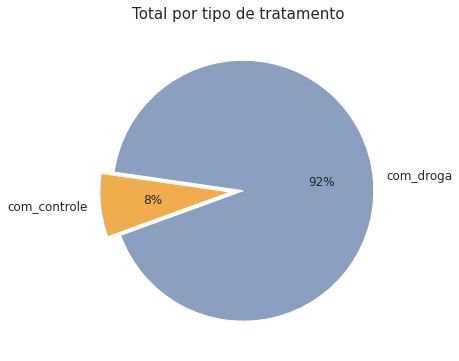

In [156]:
plot_chart_pie(series_experiments_count_tratamento, \
               title='Total por tipo de tratamento', \
               startangle= 200, \
               explode = (0, 0.1))

O que observamos é que a predominância para os **"tratamentos"** são aqueles que que testam algum tipo de composto químico. Talvez possamos partir da suposição que os percentual de análise que temos para os **"tratamentos"** do tipo **"com_controle"**, têm como objetivo termos uma referência de **"normalidade"** afim de comparação com os testes que são utilizados compostos químicos? Vamos incluir nas lista de hipóteses para validarmos depois que conhecermos melhor os dados

#### Exploração coluna: tempo

Agora vamos dar uma olhada no conteúdo da coluna **"tempo"**.

In [157]:
df_experiments['tempo'].unique()

array([24, 72, 48])

Como podemos perceber a coluna **"tempo"** possui um domínio de dados fechado. O suposição que faço em cima destes dados é que são referente aos períodos de acompanhamento de um experimento nos perídos de **24, 48 e 72 horas**. 

Dado que vimos que temos um **"id"** único para cada linha do nosso dataset, cujo representa uma **execução de teste**, será que seria um hipótese válida, assim com temos uma para a referência de "normalidade" que um mesmo "contexto" de experimento pode ter linhas que representem acompahamentos na mesma janela de tempo para validar os efeitos dos compostos químicos? Vamos incluir na lista de hipóteses para ver se achamos uma resposta para teste ponto também. 

#### Exploração coluna: dose

Agora vamos analisar o conteúdo da coluna **"dose"**.

In [158]:
df_experiments['dose'].unique()

array(['D1', 'D2'], dtype=object)

Pelo que podemos ver temos dois **"níveis"** de dosagem que são aplicados nos experimentos: D1 e D2. São valores bem subjetivos e não conseguimos ter uma noção clara do seu impacto nos experimentos que foram realizados.

O que podemos explorar neste momento são talvez as proporções das de aplicação desta dosagens no nosso dataset?

In [159]:
series_experiments_count_dose = df_experiments['dose'].value_counts(normalize=True)
series_experiments_count_dose * 100

D1    51.007811
D2    48.992189
Name: dose, dtype: float64

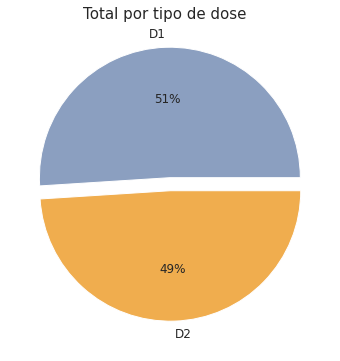

In [160]:
plot_chart_pie(series_experiments_count_dose, \
               title='Total por tipo de dose', \
               explode=(0.1, 0))

Como podemos perceber, a proproção de experimentos com os dois níveis de dosagem parecem ser bem próximos

#### Exploração coluna: droga

Agora vamos analisar o conteúdo da coluna **"droga"**

In [161]:
df_experiments['droga'].unique()

array(['b68db1d53', 'df89a8e5a', '18bb41b2c', ..., '573c787a2',
       'b2fe3eca7', 'dd4a96d16'], dtype=object)

Como podemos perceber temos um conjunto grade de compostos químicos (drogas) que foram utilizadas nos experimentos. Tavlez para termos uma maior noção, podemos agrupar e contabilizar as drogas e ordernar elas por maior ocorrência 

In [162]:
series_experiments_count_droga = df_experiments['droga'].value_counts()
series_experiments_count_droga

cacb2b860    1866
87d714366     718
9f80f3f77     246
8b87a7a83     203
5628cb3ee     202
             ... 
c5ffd58ca       1
f2cc15da6       1
7b1ac15fc       1
98c94f9b9       1
f5c443039       1
Name: droga, Length: 3289, dtype: int64

Como podemos ver neste resultado temos *3.289* compostos químicos sendo usados neste dataset. Vamos tentar trabalhar os valores de contagem para entender a abrangência com que os compostos são usados repetidamente em experimentos.

In [163]:
print('Frequência de uso de compostos químicos em experimentos\n\n -> ' + ', '.join(map(str, (list(dict.fromkeys(series_experiments_count_droga.values))))))

Frequência de uso de compostos químicos em experimentos

 -> 1866, 718, 246, 203, 202, 196, 194, 186, 178, 19, 18, 14, 13, 12, 11, 8, 7, 6, 5, 4, 3, 2, 1


Acredito que para análises que iremos realizar na sequência, talvez seja o suficiente analisarmos os **top 5** compostos, que no caso seriam:

In [164]:
top_5_drogas = series_experiments_count_droga[:5]
top_5_drogas 

cacb2b860    1866
87d714366     718
9f80f3f77     246
8b87a7a83     203
5628cb3ee     202
Name: droga, dtype: int64

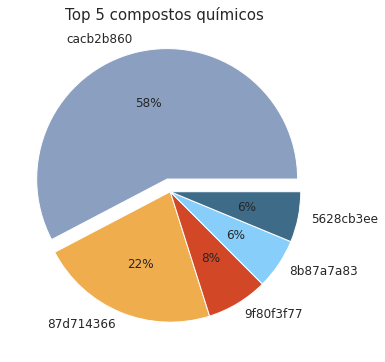

In [165]:
plot_chart_pie(top_5_drogas, \
               title='Top 5 compostos químicos', \
               explode = (0.1, 0, 0, 0, 0))

O interessante de analisar nesta visualização é que o composto químico **'cacb2b860'** foi de uso predominante nos experimentos.

#### Antes de seguirmos adiante, vamos conversar um pouco sobre expressão gênica?
<br />
Segundo o texto "Expressão gênica: o caminho da informação biológica" (EXPRESSÃO, 2021), toda a informação necessária gerar e manter ser vivo vem da molécula de DNA. Molécula que reside no núcleo de uma célula.

Quando falamos de seres vivos como nós, os humanos, em cada uma de nossas células, possuímos exatamente 46 DNAs, onde metade delas, 23, são de origem materna e outra metade são de origem paterna.

Um DNA por sua vez pode ser decomposto em 'genes', onde cada um deles, possuem informações que quando estimuladas, produzem proteínas. Muitas delas, você até já pode ter ouvido falar, tais como: insulina, anticorpos, hemoglobina, lactase, actina, colágeno e etc.

![DNA ](https://github.com/wfercosta/imersao-dados-desafio-final/raw/main/Notebooks/dna_gene.png?raw=true)

Você se recorda que pacientes que fazem tratamento de diabetes, precisam regularizar a produção 'insulina'? Pois bem, os estudos que estamos analisando são de compostos quimicos que estimulam estes 'genes' a produzir, por exemplo, a insulina que estes pacientes de diabetes tanto necessitam. Connectou os assuntos? ;-)

Mas agora você deve estar se perguntando como isso funciona certo? Vamos analisar o passo a passo da imagem a seguir:

![Célula](https://github.com/wfercosta/imersao-dados-desafio-final/raw/main/Notebooks/celula.png?raw=true)

Quando ingerimos leite, no final estamos ingerindo lactose, certo? Quando isso ocorre a lactso estimula um gene chamado de LTC, cujo possui a receita para gerar a proteína chamada de lactase, cujo é resposávelp or nos ajudar a digerir o leite.  Quando este estímulo ocorre, a receita do LTC é copiada para dentro de uma molécula de RNA, que seria o nosso mensagereio, que leva a infomrmação para fora do núcleo, até cheganar na fábrica de proteínas, que no casso é o ribossomo. O ribossomo por sua vez, lê esta receita e inicia a produção da enzima que vai nos ajudar no processo de digestáo da lactose do leite. 

Quando este processo ocorre, falamos que "expressão gênica" aumentou.

![Expressão Genica](https://github.com/wfercosta/imersao-dados-desafio-final/raw/main/Notebooks/expressao_genica.png?raw=true)

Aumentar ou diminuir a "expressão gênica" de acordo com a necessidade é uma função básica das nossas células, que podem ser esimuladas por fatores internos, como os hormônios; ou por fatores externos como, medicamentos ou alimientação.

![RNA estímulo](https://github.com/wfercosta/imersao-dados-desafio-final/raw/main/Notebooks/rna_estimulo.png?raw=true)


No desenho acima você pode perceber que temos um 'gene', em seu estado de 'controle' onde ele produz 4 RNA (e diretamente porprocional 4 proteínas). E outras duas representações, com base em algum fator interno ou externo, que estimula ou o aumento ou a redução da produção da proteina. Se voltarmos ao caso da insulina, o que temos é um composto que aumenta a produção de RNA (e consequentimente proteínas) para suprir um défict da sua produção.

Mas agora você deve estar dizendo para si mesmo: "Ok, entendi. Mas por que precisamos falar disso neste momento?". 

Bom, preicsamos um pouco deste contexto, por que as colunas que vamos explorar e analisar a seguir são as prefixadas com 'g' e 'c'. Estas são respectivamente, (tipo)'gene' e o (tipo)'celula' que foram utilizadas nos experimentos presentes nos nossos dataset.


<br />

_* As imagens apresentadas neste texto foram tiradas do texto, "Expressão gênica: o caminho da informação biológica". (EXPRESSÃO, 2021)._

<br />

#### Exploração coluna: prefixadas com 'g' e 'c'

Agora vamos começar a analisar as colunas prefixadas com **'g'** (g-n) e com **'c'** (c-n).

Como estes dados tem uma quantidade razável de informações, vamos tentar gerar algumas visualizações com estatítiscas básicas de agrupamento e depois vamos explorar o espectro de colunas, focando em algumas do início, meio e fim.

O primeiro passo é dar uma olhanda mais ampla nos valores da colunas mas analisando um espectro de: 'g-0', 'g-1', 'g-3', 'g-384', 'g-385', 'g-386', 'g-769', 'g-770' e 'g-771'

In [166]:
gn_spectrum = ['g-0', 'g-1', 'g-3', 'g-384', 'g-385', 'g-386', 'g-769', 'g-770', 'g-771']

In [167]:
series_experiments_describe_g_spectrum = df_experiments[gn_spectrum].describe()
series_experiments_describe_g_spectrum

,g-0,g-1,g-3,g-384,g-385,g-386,g-769,g-770,g-771
count,23814.000000,23814.000000,23814.000000,23814.000000,23814.000000,23814.000000,23814.000000,23814.000000,23814.000000
mean,0.248366,-0.095684,0.081971,-0.061957,-0.198694,0.261760,-0.128018,-0.219210,0.101524
std,1.393399,0.812363,0.950012,0.985407,1.831446,1.665347,1.230636,1.326193,1.417674
min,-5.513000,-5.737000,-5.998000,-10.000000,-10.000000,-10.000000,-10.000000,-10.000000,-10.000000
25%,-0.473075,-0.562200,-0.429575,-0.510475,-0.487475,-0.525275,-0.544600,-0.554400,-0.523800
50%,-0.008850,-0.046600,0.008050,0.002900,0.042700,-0.037900,0.000600,0.028700,-0.006500
75%,0.525700,0.403075,0.463400,0.484000,0.562375,0.519475,0.498500,0.496400,0.536950
max,10.000000,5.039000,10.000000,6.292000,10.000000,10.000000,5.911000,10.000000,10.000000


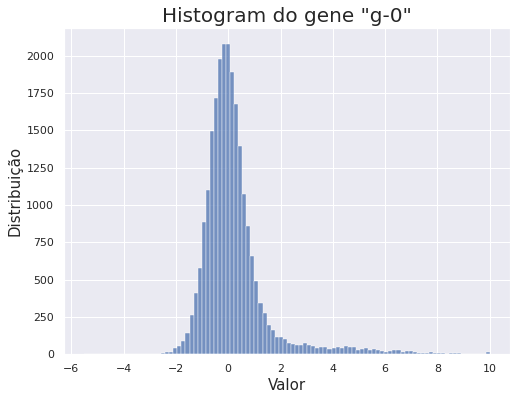

In [168]:
plot_chart_histogram(df_experiments[gn_spectrum[0]], \
                     title='Histogram do gene "%s"' % (gn_spectrum[0]), \
                     x_label='Valor', \
                     y_label='Distribuição')

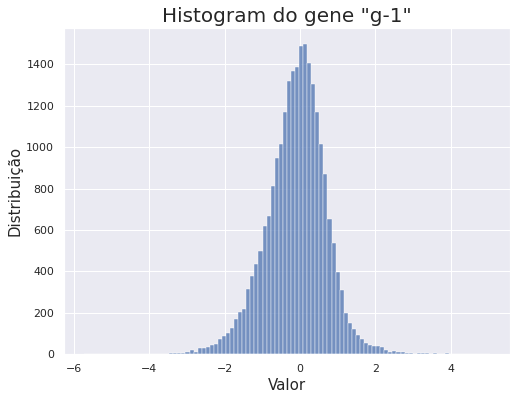

In [169]:
plot_chart_histogram(df_experiments[gn_spectrum[1]], \
                     title='Histogram do gene "%s"' % (gn_spectrum[1]), \
                     x_label='Valor', \
                     y_label='Distribuição')

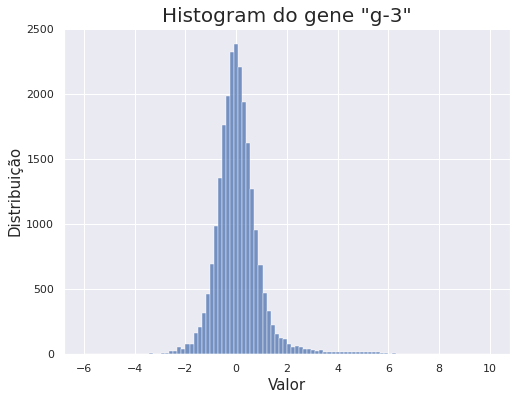

In [170]:
plot_chart_histogram(df_experiments[gn_spectrum[2]], \
                     title='Histogram do gene "%s"' % (gn_spectrum[2]), \
                     x_label='Valor', \
                     y_label='Distribuição')

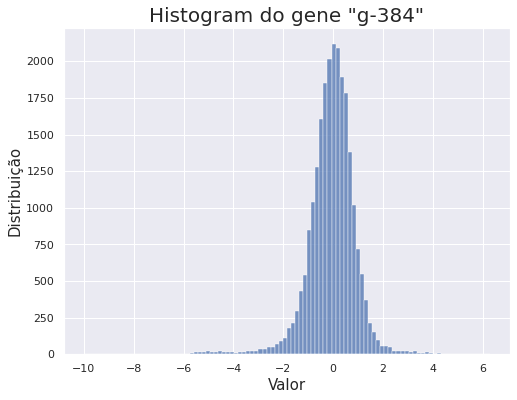

In [171]:
plot_chart_histogram(df_experiments[gn_spectrum[3]], \
                     title='Histogram do gene "%s"' % (gn_spectrum[3]), \
                     x_label='Valor', \
                     y_label='Distribuição')

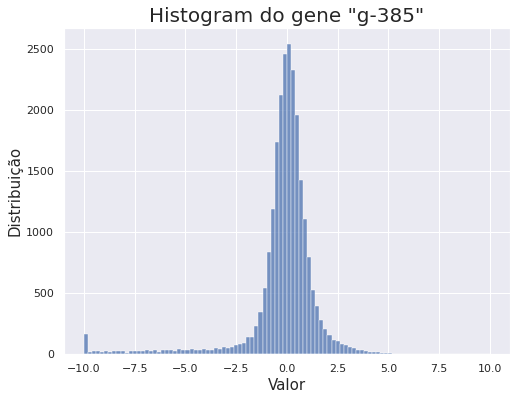

In [172]:
plot_chart_histogram(df_experiments[gn_spectrum[4]], \
                     title='Histogram do gene "%s"' % (gn_spectrum[4]), \
                     x_label='Valor', \
                     y_label='Distribuição')

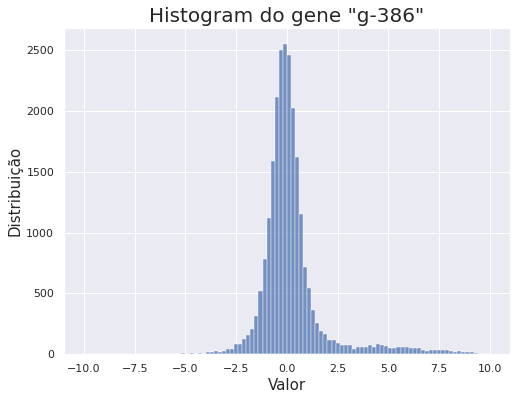

In [173]:
plot_chart_histogram(df_experiments[gn_spectrum[5]], \
                     title='Histogram do gene "%s"' % (gn_spectrum[5]), \
                     x_label='Valor', \
                     y_label='Distribuição')

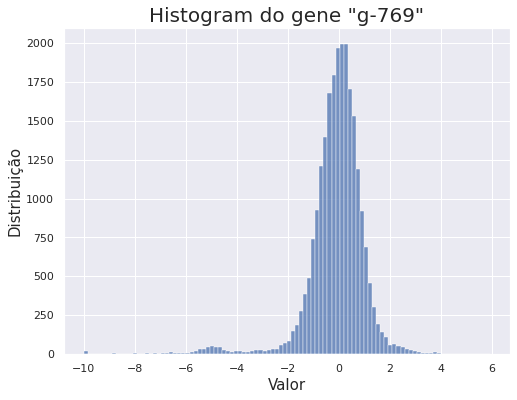

In [174]:
plot_chart_histogram(df_experiments[gn_spectrum[6]], \
                     title='Histogram do gene "%s"' % (gn_spectrum[6]), \
                     x_label='Valor', \
                     y_label='Distribuição')

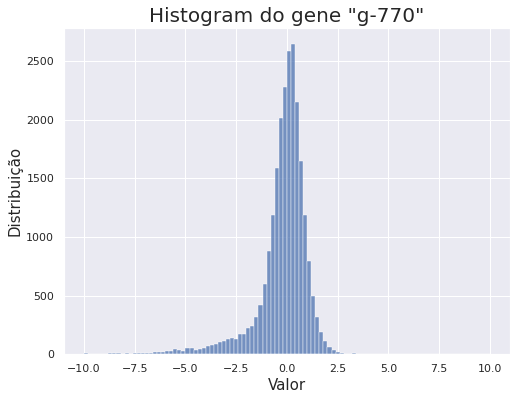

In [175]:
plot_chart_histogram(df_experiments[gn_spectrum[7]], \
                     title='Histogram do gene "%s"' % (gn_spectrum[7]), \
                     x_label='Valor', \
                     y_label='Distribuição')

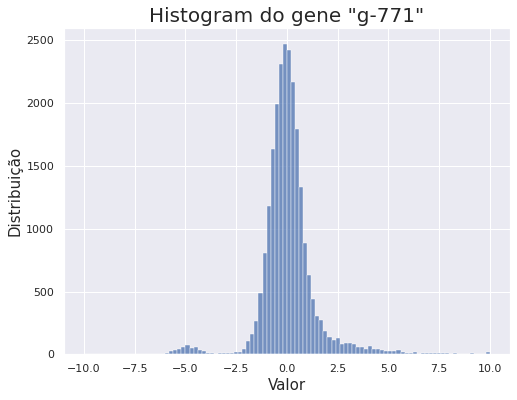

In [176]:
plot_chart_histogram(df_experiments[gn_spectrum[8]], \
                     title='Histogram do gene "%s"' % (gn_spectrum[8]), \
                     x_label='Valor', \
                     y_label='Distribuição')

Agora vamos analisar o espector completo dos genes, mas sob uma visão "agrupada", usando estatísticas básicas como: média, máximo, mínio e o desvio padrão.

In [177]:
series_experiments_describe_g = df_experiments.loc[:, 'g-0':'g-771'].describe()
series_experiments_describe_g

,g-0,g-1,g-2,g-3,g-4,g-5,g-6,g-7,g-8,g-9,g-10,g-11,g-12,g-13,g-14,g-15,g-16,g-17,g-18,g-19,g-20,g-21,g-22,g-23,g-24,g-25,g-26,g-27,g-28,g-29,g-30,g-31,g-32,g-33,g-34,g-35,g-36,g-37,g-38,g-39,...,g-732,g-733,g-734,g-735,g-736,g-737,g-738,g-739,g-740,g-741,g-742,g-743,g-744,g-745,g-746,g-747,g-748,g-749,g-750,g-751,g-752,g-753,g-754,g-755,g-756,g-757,g-758,g-759,g-760,g-761,g-762,g-763,g-764,g-765,g-766,g-767,g-768,g-769,g-770,g-771
count,23814.000000,23814.000000,23814.000000,23814.000000,23814.000000,23814.000000,23814.000000,23814.000000,23814.000000,23814.000000,23814.000000,23814.000000,23814.000000,23814.000000,23814.000000,23814.000000,23814.000000,23814.000000,23814.000000,23814.000000,23814.000000,23814.000000,23814.000000,23814.000000,23814.000000,23814.000000,23814.000000,23814.000000,23814.000000,23814.000000,23814.000000,23814.000000,23814.000000,23814.000000,23814.000000,23814.000000,23814.000000,23814.000000,23814.000000,23814.000000,...,23814.000000,23814.000000,23814.000000,23814.000000,23814.000000,23814.000000,23814.000000,23814.000000,23814.000000,23814.000000,23814.000000,23814.000000,23814.000000,23814.000000,23814.000000,23814.000000,23814.000000,23814.000000,23814.000000,23814.000000,23814.000000,23814.000000,23814.000000,23814.000000,23814.000000,23814.000000,23814.000000,23814.000000,23814.000000,23814.000000,23814.000000,23814.000000,23814.000000,23814.000000,23814.000000,23814.000000,23814.000000,23814.000000,23814.000000,23814.000000
mean,0.248366,-0.095684,0.152253,0.081971,0.057347,-0.138836,0.035961,-0.202651,-0.190083,0.119905,-0.123321,0.182307,0.143203,0.209402,-0.173884,-0.024432,0.126823,-0.146663,0.087687,-0.082982,-0.111908,-0.087379,0.047548,-0.117474,-0.113212,-0.052746,-0.091055,0.112176,-0.046458,-0.076239,-0.197699,0.382177,-0.189432,0.078791,-0.093312,0.135729,-0.188616,-0.606710,0.534425,0.132026,...,0.263569,-0.242638,0.110180,-0.039868,-0.064056,0.193629,0.004470,-0.187085,0.067186,0.006159,-0.201189,-0.243317,0.548903,0.247065,0.085950,0.090544,0.215525,-0.007705,0.236954,0.022785,0.103224,0.048402,0.109367,-0.103262,0.004129,0.066211,0.072773,-0.033051,-0.400643,-0.338978,0.207299,0.009161,0.171027,0.002316,-0.209799,-0.076251,0.134162,-0.128018,-0.219210,0.101524
std,1.393399,0.812363,1.035731,0.950012,1.032091,1.179388,0.882395,1.125494,1.749885,1.087180,1.291501,1.253604,1.234590,1.273068,1.247178,0.659839,1.418997,1.179688,0.743301,0.844796,1.219529,0.824401,0.924838,0.760159,1.203186,0.866977,1.103765,1.001687,1.027758,1.279399,1.302567,1.559174,0.933514,1.172270,1.174325,1.061719,1.397677,2.200277,2.003317,0.990477,...,1.075809,1.309482,0.881283,0.917119,1.186966,1.212621,1.175611,1.182180,1.057292,0.996940,1.029370,1.378815,2.023791,1.639307,1.238753,0.961212,1.293783,0.966213,1.284074,1.015557,1.035968,1.048645,0.856080,1.175372,0.701031,0.996914,1.077310,1.579948,1.913468,1.701554,1.096488,1.200395,1.357701,1.052771,1.201918,1.115477,0.951264,1.230636,1.326193,1.417674
min,-5.513000,-5.737000,-9.104000,-5.998000,-6.369000,-10.000000,-10.000000,-10.000000,-10.000000,-8.337000,-10.000000,-5.870000,-8.587000,-5.018000,-10.000000,-10.000000,-10.000000,-10.000000,-4.226000,-10.000000,-10.000000,-5.700000,-10.000000,-10.000000,-10.000000,-8.272000,-8.184000,-4.835000,-7.913000,-10.000000,-10.000000,-2.956000,-8.356000,-7.182000,-10.000000,-9.261000,-10.000000,-10.000000,-10.000000,-4.223000,...,-5.504000,-10.000000,-3.790000,-10.000000,-10.000000,-10.000000,-7.920000,-10.000000,-9.462000,-6.634000,-10.000000,-10.000000,-2.912000,-9.833000,-7.227000,-5.561000,-8.393000,-5.790000,-4.915000,-10.000000,-10.000000,-7.918000,-5.255000,-10.000000,-6.264000,-10.000000,-5.505000,-10.000000,-10.000000,-10.000000,-8.193000,-10.000000,-9.795000,-8.180000,-10.000000,-10.000000,-4.269000,-10.000000,-10.000000,-10.000000
25%,-0.473075,-0.562200,-0.437750,-0.429575,-0.470925,-0.602225,-0.493900,-0.525175,-0.511675,-0.360200,-0.511475,-0.489675,-0.447500,-0.481200,-0.607975,-0.404150,-0.391950

Visão das médias de todas as colunas

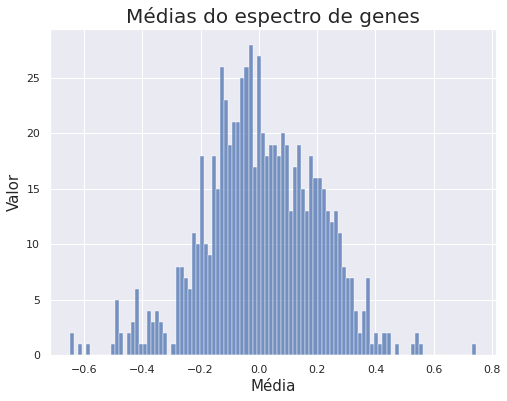

In [178]:
plot_chart_histogram(series_experiments_describe_g.T['mean'], \
                     title='Médias do espectro de genes', \
                     x_label='Média', \
                     y_label='Valor')

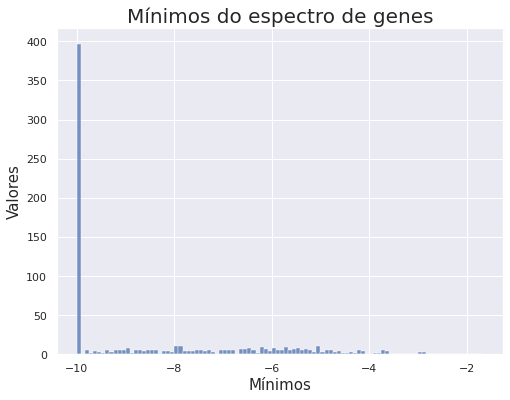

In [179]:
plot_chart_histogram(series_experiments_describe_g.T['min'], \
                     title='Mínimos do espectro de genes', \
                     x_label='Mínimos', \
                     y_label='Valores')

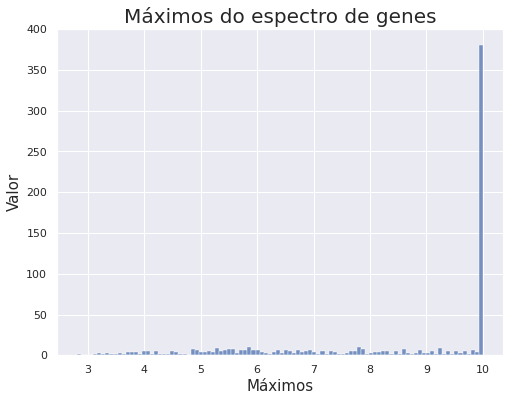

In [180]:
plot_chart_histogram(series_experiments_describe_g.T['max'], \
                     title='Máximos do espectro de genes', \
                     x_label='Máximos', \
                     y_label='Valor')

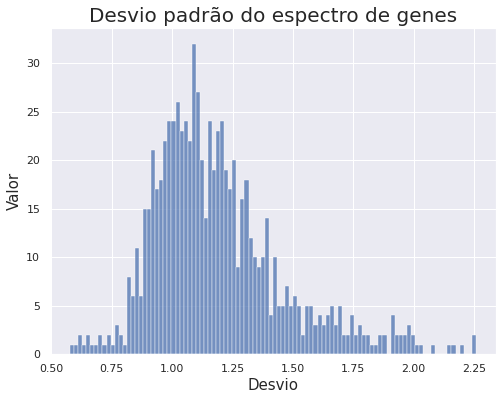

In [181]:
plot_chart_histogram(series_experiments_describe_g.T['std'], \
                     title='Desvio padrão do espectro de genes', \
                     x_label='Desvio', \
                     y_label='Valor')

Bom, a única conclusão que consigo tirar destes dados neste momento é quanto a aplicação de uma regra para normalização dos números para que não fiquem tão distantes.

Um ponto que podemos ter como uma suspeita é que quanto mais próximos de zero (0), mais próximo o gene está do seu comportamento normal e quanto mais longe de zero, se para um número mais positivo ou mais negativo, respectivamente, mais ativado ou menos ativado o está o gene?

Será que se pegarmos alguns experimentos por amostragem e cruzarmos com a tabela de resultados, podemos inferir melhor esta suspeita?

Agora vamos fazer o mesmo trabalho com as células: 'c-0', 'c-1', 'c-3', 'c-48', 'c-49', 'c-50', 'c-97', 'c-98' e 'c-99'

In [182]:
cn_spectrum = ['c-0', 'c-1', 'c-3', 'c-48', 'c-49', 'c-50', 'c-97', 'c-98', 'c-99']

In [183]:
series_experiments_describe_c_spectrum = df_experiments[cn_spectrum].describe()
series_experiments_describe_c_spectrum

,c-0,c-1,c-3,c-48,c-49,c-50,c-97,c-98,c-99
count,23814.000000,23814.000000,23814.000000,23814.000000,23814.000000,23814.000000,23814.000000,23814.000000,23814.000000
mean,-0.355156,-0.455359,-0.377666,-0.518600,-0.391396,-0.393122,-0.378241,-0.470252,-0.301505
std,1.752565,2.004962,1.554583,2.042422,1.721804,1.794246,1.703615,1.834828,1.407918
min,-10.000000,-10.000000,-10.000000,-10.000000,-10.000000,-10.000000,-10.000000,-10.000000,-10.000000
25%,-0.549300,-0.538425,-0.601975,-0.574050,-0.555275,-0.528475,-0.561000,-0.592600,-0.562900
50%,-0.009000,0.009800,-0.039050,-0.003850,0.004500,0.006300,-0.006800,0.014000,-0.019500
75%,0.448975,0.476875,0.413100,0.459150,0.464075,0.478000,0.446400,0.461275,0.438650
max,3.365000,3.915000,2.408000,3.371000,4.023000,6.412000,2.924000,3.111000,3.805000


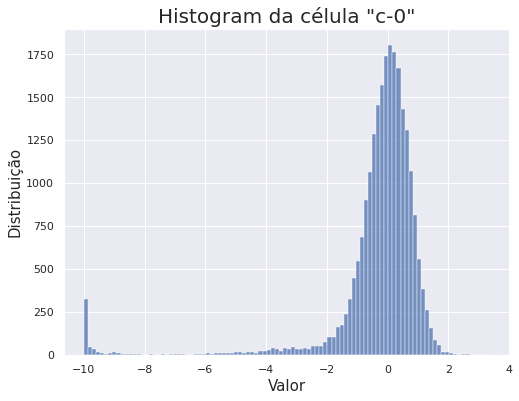

In [184]:
plot_chart_histogram(df_experiments[cn_spectrum[0]], \
                     title='Histogram da célula "%s"' % (cn_spectrum[0]), \
                     x_label='Valor', \
                     y_label='Distribuição')

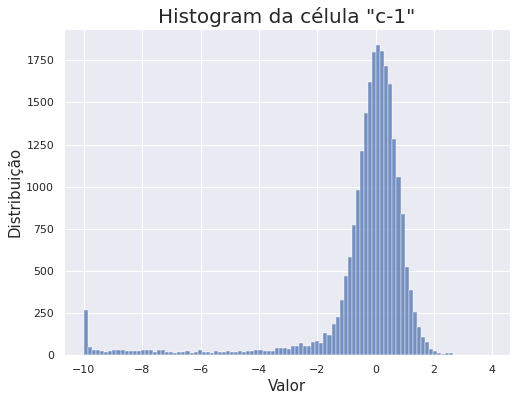

In [185]:
plot_chart_histogram(df_experiments[cn_spectrum[1]], \
                     title='Histogram da célula "%s"' % (cn_spectrum[1]), \
                     x_label='Valor', \
                     y_label='Distribuição')

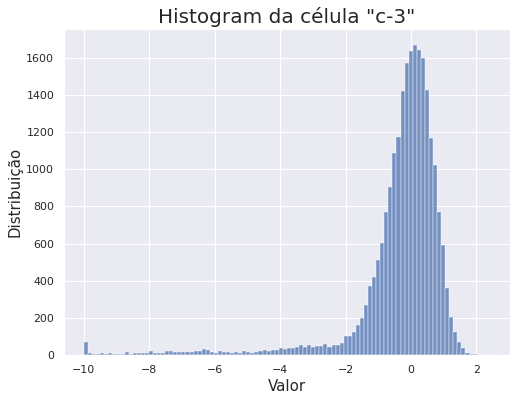

In [186]:
plot_chart_histogram(df_experiments[cn_spectrum[2]], \
                     title='Histogram da célula "%s"' % (cn_spectrum[2]), \
                     x_label='Valor', \
                     y_label='Distribuição')

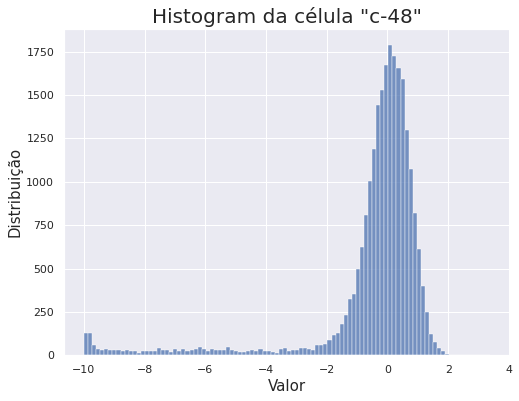

In [187]:
plot_chart_histogram(df_experiments[cn_spectrum[3]], \
                     title='Histogram da célula "%s"' % (cn_spectrum[3]), \
                     x_label='Valor', \
                     y_label='Distribuição')

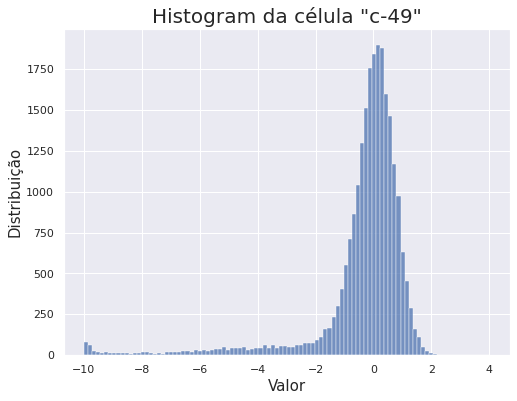

In [188]:
plot_chart_histogram(df_experiments[cn_spectrum[4]], \
                     title='Histogram da célula "%s"' % (cn_spectrum[4]), \
                     x_label='Valor', \
                     y_label='Distribuição')

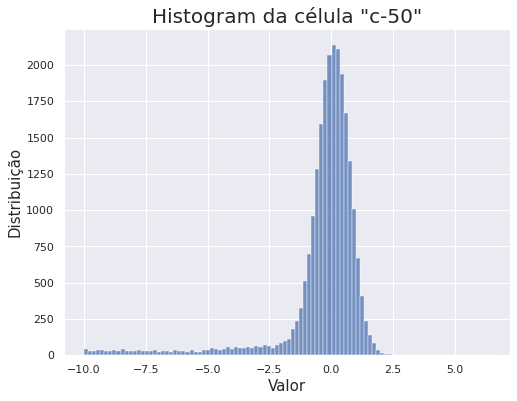

In [189]:
plot_chart_histogram(df_experiments[cn_spectrum[5]], \
                     title='Histogram da célula "%s"' % (cn_spectrum[5]), \
                     x_label='Valor', \
                     y_label='Distribuição')

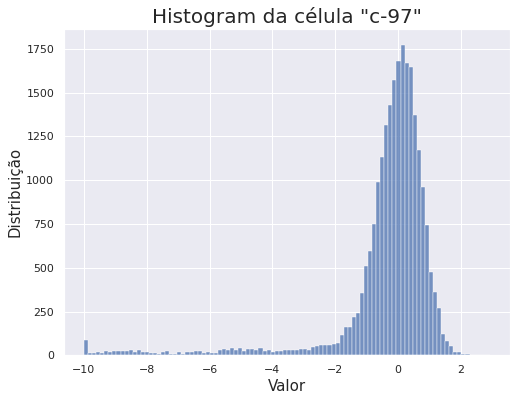

In [190]:
plot_chart_histogram(df_experiments[cn_spectrum[6]], \
                     title='Histogram da célula "%s"' % (cn_spectrum[6]), \
                     x_label='Valor', \
                     y_label='Distribuição')

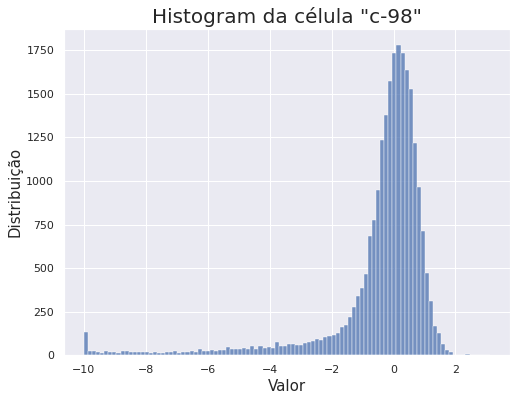

In [191]:
plot_chart_histogram(df_experiments[cn_spectrum[7]], \
                     title='Histogram da célula "%s"' % (cn_spectrum[7]), \
                     x_label='Valor', \
                     y_label='Distribuição')

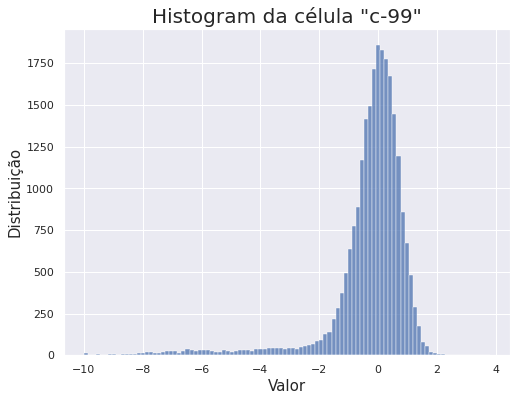

In [192]:
plot_chart_histogram(df_experiments[cn_spectrum[8]], \
                     title='Histogram da célula "%s"' % (cn_spectrum[8]), \
                     x_label='Valor', \
                     y_label='Distribuição')

In [193]:
series_experiments_describe_c = df_experiments.loc[:, 'c-0':'c-99'].describe()
series_experiments_describe_c

,c-0,c-1,c-2,c-3,c-4,c-5,c-6,c-7,c-8,c-9,c-10,c-11,c-12,c-13,c-14,c-15,c-16,c-17,c-18,c-19,c-20,c-21,c-22,c-23,c-24,c-25,c-26,c-27,c-28,c-29,c-30,c-31,c-32,c-33,c-34,c-35,c-36,c-37,c-38,c-39,...,c-60,c-61,c-62,c-63,c-64,c-65,c-66,c-67,c-68,c-69,c-70,c-71,c-72,c-73,c-74,c-75,c-76,c-77,c-78,c-79,c-80,c-81,c-82,c-83,c-84,c-85,c-86,c-87,c-88,c-89,c-90,c-91,c-92,c-93,c-94,c-95,c-96,c-97,c-98,c-99
count,23814.000000,23814.000000,23814.000000,23814.000000,23814.000000,23814.000000,23814.000000,23814.000000,23814.000000,23814.000000,23814.000000,23814.000000,23814.000000,23814.000000,23814.000000,23814.000000,23814.000000,23814.000000,23814.000000,23814.000000,23814.000000,23814.000000,23814.000000,23814.000000,23814.000000,23814.000000,23814.000000,23814.000000,23814.000000,23814.000000,23814.000000,23814.000000,23814.000000,23814.000000,23814.000000,23814.000000,23814.000000,23814.000000,23814.000000,23814.000000,...,23814.000000,23814.000000,23814.000000,23814.000000,23814.000000,23814.000000,23814.000000,23814.000000,23814.000000,23814.000000,23814.000000,23814.000000,23814.000000,23814.000000,23814.000000,23814.000000,23814.000000,23814.000000,23814.000000,23814.000000,23814.000000,23814.000000,23814.000000,23814.000000,23814.000000,23814.000000,23814.000000,23814.000000,23814.000000,23814.000000,23814.000000,23814.000000,23814.000000,23814.000000,23814.000000,23814.000000,23814.000000,23814.000000,23814.000000,23814.000000
mean,-0.355156,-0.455359,-0.480542,-0.377666,-0.493552,-0.446037,-0.574855,-0.266293,-0.451307,-0.458664,-0.486027,-0.473410,-0.508091,-0.510905,-0.306528,-0.452293,-0.337267,-0.473728,-0.619461,-0.330389,-0.454165,-0.496059,-0.383134,-0.295655,-0.443384,-0.449683,-0.597730,-0.431899,-0.501831,-0.288958,-0.385486,-0.434420,-0.322990,-0.545691,-0.461527,-0.350457,-0.477049,-0.209301,-0.598003,-0.397430,...,-0.517397,-0.360770,-0.435752,-0.613591,-0.402083,-0.619682,-0.452265,-0.497164,-0.413836,-0.277029,-0.547845,-0.358611,-0.442906,-0.475194,-0.010404,-0.467001,-0.276963,-0.455848,-0.412918,-0.456404,-0.472514,-0.505481,-0.492735,-0.446836,-0.463029,-0.409310,-0.333124,-0.295009,-0.328342,-0.401615,-0.469244,-0.461411,-0.513256,-0.500142,-0.507093,-0.353726,-0.463485,-0.378241,-0.470252,-0.301505
std,1.752565,2.004962,2.039346,1.554583,2.091888,1.893484,2.234152,1.465313,1.948829,1.646122,2.066695,2.058766,2.140051,2.170919,1.575507,1.974010,1.594663,2.079550,2.294899,1.641563,2.001374,2.023053,1.690235,1.536784,1.967079,1.899095,2.268931,1.916467,1.904629,1.521773,1.741182,1.988458,1.772399,2.201552,1.974772,1.751440,1.965178,1.287766,2.297375,1.838205,...,2.122318,1.710725,1.898871,2.307820,1.785055,2.225596,1.991021,2.063896,1.887001,1.459639,2.187835,1.730634,1.924716,2.021927,1.029820,2.004317,1.429340,1.924263,1.888788,1.832863,2.011396,2.091353,2.055624,1.987476,2.014045,1.883974,1.647241,1.634073,1.663170,1.832794,2.000488,2.042475,2.001714,2.107105,2.159589,1.629291,2.059725,1.703615,1.834828,1.407918
min,-10.000000,-10.000000,-10.000000,-10.000000,-10.000000,-10.000000,-10.000000,-10.000000,-10.000000,-10.000000,-10.000000,-10.000000,-10.000000,-10.000000,-10.000000,-10.000000,-10.000000,-10.000000,-10.000000,-10.000000,-10.000000,-10.000000,-10.000000,-10.000000,-10.000000,-10.000000,-10.000000,-10.000000,-10.000000,-10.000000,-10.000000,-10.000000,-10.000000,-10.000000,-10.000000,-10.000000,-10.000000,-9.910000,-10.000000,-10.000000,...,-10.000000,-10.000000,-10.000000,-10.000000,-10.000000,-10.000000,-10.000000,-10.000000,-10.000000,-9.839000,-10.000000,-10.000000,-10.000000,-10.000000,-6.452000,-10.000000,-9.938000,-10.000000,-10.000000,-10.000000,-10.000000,-10.000000,-10.000000,-10.000000,-10.000000,-10.000000,-10.000000,-10.000000,-10.000000,-10.000000,-10.000000,-10.000000,-10.000000,-10.000000,-10.000000,-10.000000,-10.000000,-10.000000,-10.000000,-10.000000
25%,-0.549300,-0.538425,-0.550375,-0.601975,-0.559975,-0.578775,-0.571250,-0.524275,-0.551100,-0.654675,-0.564000,-0.546475,-0.555500,

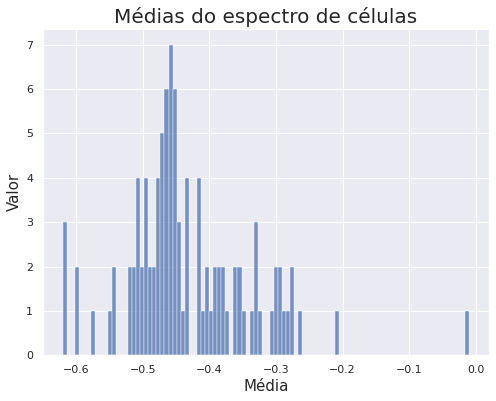

In [194]:
plot_chart_histogram(series_experiments_describe_c.T['mean'], \
                     title='Médias do espectro de células', \
                     x_label='Média', \
                     y_label='Valor')

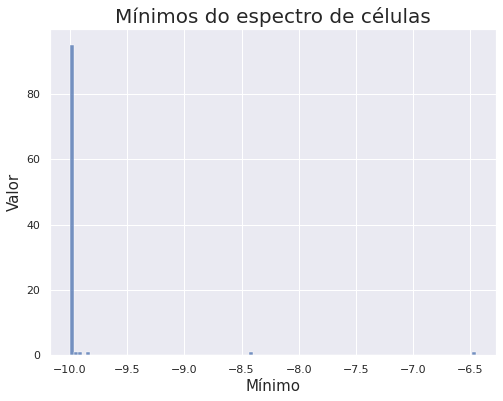

In [195]:
plot_chart_histogram(series_experiments_describe_c.T['min'], \
                     title='Mínimos do espectro de células', \
                     x_label='Mínimo', \
                     y_label='Valor')

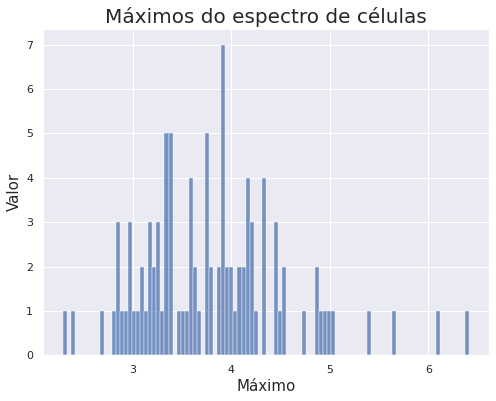

In [196]:
plot_chart_histogram(series_experiments_describe_c.T['max'], \
                     title='Máximos do espectro de células', \
                     x_label='Máximo', \
                     y_label='Valor')

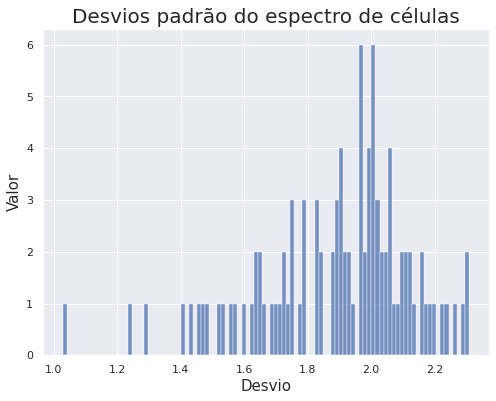

In [197]:
plot_chart_histogram(series_experiments_describe_c.T['std'], \
                     title='Desvios padrão do espectro de células', \
                     x_label='Desvio', \
                     y_label='Valor')

Quando analisamos os números para as células (c-n) vemos que os valores também foram normalizados para não termos variações táo descrepantes.


Analisando estes dados, tanto de **"g-n"** quanto de **"c-n"**, a hipótese que me ocorre é que dado que uma expressão gênica é um ciclo que vai:  **Da ativação de um gene DNA -> seu transporte via RNA -> sua produção de proteína**; acredito que seria plausível dizer que um composto químico para ativar um tipo específico de *gene*, por mais que todas as células tenham este "gene" no seu núcleo, não necessariamente a célula vai responder a fabricação da proteína. Logo, hipotéticamente, uma célula com uma determinada patologia seria incapaz de produzir a proteina mesmo ela recebendo o RNA do gene ativado? 

### Dados referentes aos resultados dos experimentos

#### Visão geral do dataset

In [198]:
df_experiments_results.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23814 entries, 0 to 23813
Columns: 207 entries, id to wnt_inhibitor
dtypes: int64(206), object(1)
memory usage: 37.6+ MB


Como podemos ver, neste dataset temos a mesma quantidade de linhas do dataset anterior, neste caso **23.814**, onde podemos assumir que cada ocorrência desta tabela refere-se tem um experimento correspondente. Adicionalmente, podemos notar que há menos colunas. Um total de **207**. Vamos listar as colunas que temos presentes no nosso dataset.

In [199]:
print_df_dict_groupby(df_experiments_results \
                        .columns \
                        .to_series() \
                        .groupby(df_experiments_results.dtypes) \
                        .groups)

<class 'pandas.io.formats.printing.PrettyDict'>
int64
	5-alpha_reductase_inhibitor, 11-beta-hsd1_inhibitor, acat_inhibitor, acetylcholine_receptor_agonist, acetylcholine_receptor_antagonist, acetylcholinesterase_inhibitor, adenosine_receptor_agonist, adenosine_receptor_antagonist, adenylyl_cyclase_activator, adrenergic_receptor_agonist, adrenergic_receptor_antagonist, akt_inhibitor, aldehyde_dehydrogenase_inhibitor, alk_inhibitor, ampk_activator, analgesic, androgen_receptor_agonist, androgen_receptor_antagonist, anesthetic_-_local, angiogenesis_inhibitor, angiotensin_receptor_antagonist, anti-inflammatory, antiarrhythmic, antibiotic, anticonvulsant, antifungal, antihistamine, antimalarial, antioxidant, antiprotozoal, antiviral, apoptosis_stimulant, aromatase_inhibitor, atm_kinase_inhibitor, atp-sensitive_potassium_channel_antagonist, atp_synthase_inhibitor, atpase_inhibitor, atr_kinase_inhibitor, aurora_kinase_inhibitor, autotaxin_inhibitor, bacterial_30s_ribosomal_subunit_inhibitor, 

Aqui podemos notar que temos a coluna **"id"** o que possívelmente nos dá a possibilidade de relacionar com os dados do dataset anterior. Nota sse também algumas colunas com uma possibiliade maior de significado e com sufixos que se repentem, tais como:
* inibinator
* receptor agonist 
* receptor antagonist
* channel activator

Vamos visualizar os dados para tentar entender melhor.

In [200]:
df_experiments_results

,id,5-alpha_reductase_inhibitor,11-beta-hsd1_inhibitor,acat_inhibitor,acetylcholine_receptor_agonist,acetylcholine_receptor_antagonist,acetylcholinesterase_inhibitor,adenosine_receptor_agonist,adenosine_receptor_antagonist,adenylyl_cyclase_activator,adrenergic_receptor_agonist,adrenergic_receptor_antagonist,akt_inhibitor,aldehyde_dehydrogenase_inhibitor,alk_inhibitor,ampk_activator,analgesic,androgen_receptor_agonist,androgen_receptor_antagonist,anesthetic_-_local,angiogenesis_inhibitor,angiotensin_receptor_antagonist,anti-inflammatory,antiarrhythmic,antibiotic,anticonvulsant,antifungal,antihistamine,antimalarial,antioxidant,antiprotozoal,antiviral,apoptosis_stimulant,aromatase_inhibitor,atm_kinase_inhibitor,atp-sensitive_potassium_channel_antagonist,atp_synthase_inhibitor,atpase_inhibitor,atr_kinase_inhibitor,aurora_kinase_inhibitor,...,protein_synthesis_inhibitor,protein_tyrosine_kinase_inhibitor,radiopaque_medium,raf_inhibitor,ras_gtpase_inhibitor,retinoid_receptor_agonist,retinoid_receptor_antagonist,rho_associated_kinase_inhibitor,ribonucleoside_reductase_inhibitor,rna_polymerase_inhibitor,serotonin_receptor_agonist,serotonin_receptor_antagonist,serotonin_reuptake_inhibitor,sigma_receptor_agonist,sigma_receptor_antagonist,smoothened_receptor_antagonist,sodium_channel_inhibitor,sphingosine_receptor_agonist,src_inhibitor,steroid,syk_inhibitor,tachykinin_antagonist,tgf-beta_receptor_inhibitor,thrombin_inhibitor,thymidylate_synthase_inhibitor,tlr_agonist,tlr_antagonist,tnf_inhibitor,topoisomerase_inhibitor,transient_receptor_potential_channel_antagonist,tropomyosin_receptor_kinase_inhibitor,trpv_agonist,trpv_antagonist,tubulin_inhibitor,tyrosine_kinase_inhibitor,ubiquitin_specific_protease_inhibitor,vegfr_inhibitor,vitamin_b,vitamin_d_receptor_agonist,wnt_inhibitor
0,id_000644bb2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,id_000779bfc,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,id_000a6266a,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,id_0015fd391,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,id_001626bd3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23809,id_fffb1ceed,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
23810,id_fffb70c0c,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
23811,id_fffc1c3f4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
23812,id_fffcb9e7c,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


Interessante não? Todas as colunas, exceto a *"id"*, pelo menos na amostragem do data frame, estão mostrando somente zeros. Vamos pegar duas ou três colunas para analisar o conteúdo mais a fundo

In [201]:
df_experiments_results['5-alpha_reductase_inhibitor'].value_counts()

0    23797
1       17
Name: 5-alpha_reductase_inhibitor, dtype: int64

In [202]:
df_experiments_results['vitamin_b'].value_counts()

0    23788
1       26
Name: vitamin_b, dtype: int64

In [203]:
df_experiments_results['rna_polymerase_inhibitor'].value_counts()

0    23789
1       25
Name: rna_polymerase_inhibitor, dtype: int64

In [204]:
df_experiments_results['ribonucleoside_reductase_inhibitor'].value_counts()

0    23777
1       37
Name: ribonucleoside_reductase_inhibitor, dtype: int64

Hum. O que notamos aqui é os valores das colunas somente possuem valores binários, neste caso 0 e 1. Verdadeiro ou Falso?

No caso da coluna **'ribonucleoside_reductase_inhibitor'**, realidade estamos falando de inibidor que faz parte da família dos farmacológicos anti-cancer, cujo tem como ação inteferir no crescimento de células de tumor. E para este dataset, ele foi 37 indicado como verdadeiro (RIBONUCLEOTIDE, 2020). 

Acho que podemos partir do assumption que para cada uma desta colunas se trata de um composto químico que foi acionado com sucesso ou não.


Continuando com a nossa exploração de dados, será que temos nestes resultados sem nenhum composto quimico com seu resultado como verdadeiro?

Primeiramente vamos gerar algumas colunas auxiliares para contar o numero total de compostos que ativaram e também um uma coluna booleana para sabermos se ouve algum ativo ou não

In [205]:
df_experiments_results['num_total_ativos'] = df_experiments_results.drop('id', axis=1).sum(axis=1)
df_experiments_results['has_ativos'] = df_experiments_results['num_total_ativos'] !=0

In [206]:
df_experiments_results['has_ativos'].value_counts()


True     14447
False     9367
Name: has_ativos, dtype: int64

Como podemos ver nos resulatos tivemos **1447** deles que tiveram algum tipo de ativação e **9367** que não.

Vamos tentar verificar se há correlações de ativação entre os diferente compostos

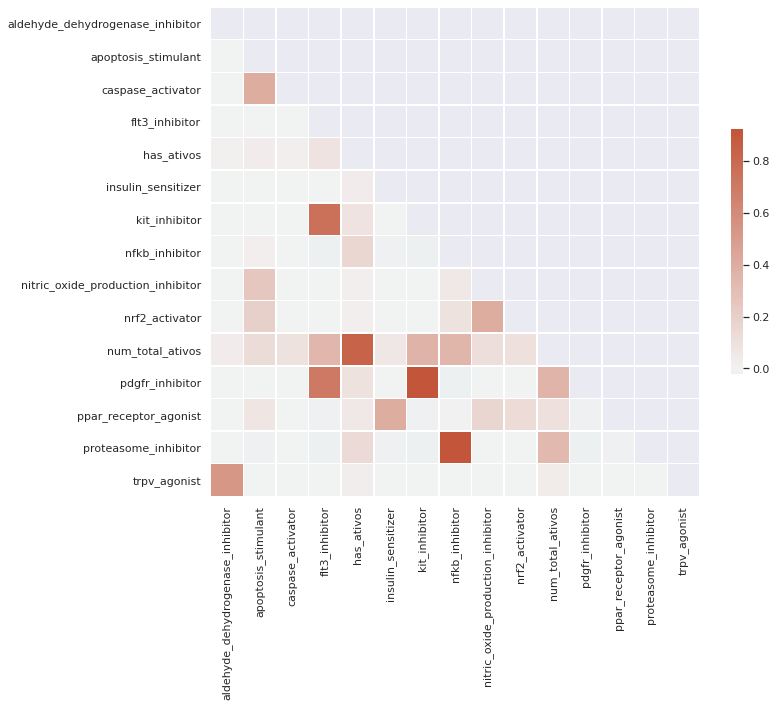

In [209]:
plot_chart_correlations_heatmap(filter_correlation(df_experiments_results.drop('id', axis=1).corr(), 0.4))

Quando aplicamos as correlações nos compostos, podemos começar a pensar que para os resultados que tem mais que um 'ativado' é por que ele tem que vir acompnhado de mais de um?

Aparentemente temos correlações bem frequentes para alguns casos.

### Hipóteses

##Bibliografia e referências

* __DRUG discovery: passado, presente e futuro__. Alura, maio de 2021. Disponível em: <https://docs.google.com/document/d/10EhrQBChlyYIcff3to7PrCQi5HcNk2r-zd2ZCKPtcz8/edit?usp=sharing>. Acesso em: 08 de maio de 2021.

* __TALEB, Nassim Nicholas__. _A Lógica do Cisne Negro: O impacto do altamente imporvável_. 18a Ed. Rio de Janeiro: Best Business, 2019.

* __CORONAVÍRUS da síndrome respiratória aguda grave 2__. In: WIKIPÉDIA: a enciclopédia livre. Wikimedia, 2021. Disponível em: <https://pt.wikipedia.org/wiki/Coronav%C3%ADrus_da_s%C3%ADndrome_respiratória_aguda_grave_2>. Acesso em: 08 de maio de 2021

* __COVID-19__. In: WIKIPÉDIA: a enciclopédia livre. Wikimedia, 2021. Disponível em: <https://pt.wikipedia.org/wiki/COVID-19>. Acesso em: 08 de maio de 2021

* __PANDEMIA__. In: WIKIPÉDIA: a enciclopédia livre. Wikimedia, 2021. Disponível em: <https://pt.wikipedia.org/wiki/Pandemia>. Acesso em: 08 de maio de 2021

* __VACINA de RNA__. In: WIKIPÉDIA: a enciclopédia livre. Wikimedia, 2021. Disponível em: <https://pt.wikipedia.org/wiki/Vacina_de_RNA>. Acesso em: 08 de maio de 2021

* __A HISTÓRIA da mulher com células imortais que salvam vidas há 60 anos__. In: BBC News. BBC, 12 de março 2017. Disponível em: <https://www.bbc.com/portuguese/internacional-39248764>. Acesso em: 08 de maio de 2021


* __EXPRESSÃO gênica: o caminho da informação biológica__. Alura, maio de 2021. Disponível em? <https://drive.google.com/file/d/1VNP08ffCiGD8cqaBkdHATWSX8Yxfm3dj/view?usp=sharing>. Acesso em: 08 de maio de 2021.

* __QUAL É A RELAÇÃO DA INSULINA COM A DIABETES?__. In: Santo Remédio. Drograria Santo Remédio, 10 de dezembro 2018. Disponível em: <https://drogariasantoremedio.com.br/qual-relacao-insulina-diabetes/>. Acesso em: 09 de maio de 2021

* __RIBONUCLEOTIDE reductase inhibitor__. In: WIKIPÉDIA: a enciclopédia livre. Wikimedia, 2020. Disponível em: <https://en.wikipedia.org/wiki/Ribonucleotide_reductase_inhibitor>. Acesso em: 09 de maio de 2021


